In the following we will use a dataset provided in the dataset collection of PyTorch Geometric ([Here you find all datasets](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html)). The Dataset comes from the MoleculeNet collection, which can be found [here](http://moleculenet.ai/datasets-1).


>"ESOL is a small dataset consisting of water solubility data for 1128 compounds. The dataset
has been used to train models that estimate solubility directly from chemical structures (as
encoded in SMILES strings). Note that these structures don’t include 3D coordinates, since
solubility is a property of a molecule and not of its particular conformers."

**>>> Machine Learning task: How are different molecules dissolving in water?**


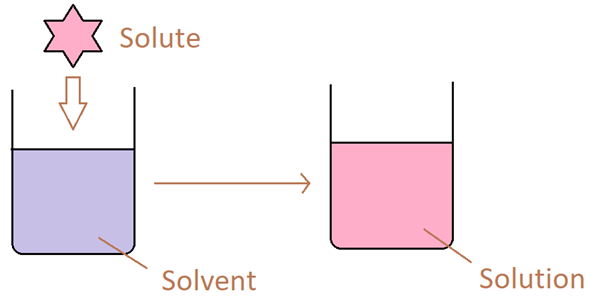

Source: https://www.differencebetween.com/difference-between-solubility-and-solubility-product/

In [1]:
#################################################
## Dataset exploration (ESOL from MoleculeNet) ##
#################################################

import rdkit
from torch_geometric.datasets import MoleculeNet

#------
## Load the ESOL dataset
#------

root_path = "/home/longdpt/Documents/Long_AISDL/DeepLearning_PyTorch/05_GNN/data"

esol = MoleculeNet(root=root_path, name="ESOL")

In [2]:
#------
## Investigate
#------

print(f"Dataset type: {type(esol)}")
print(f"Dataset features: {esol.num_features}")
print(f"Dataset target: {esol.num_classes}")
print(f"Dataset length: {esol.len()}") # has 11280 molecules (graphs)
print(f"Daset sample (the first graph/molecule): {esol[0]}") # access the first graph/molecule
print(f"Sample nodes: {esol[0].num_nodes}") # The numble of atoms
print(f"Sample node features: {esol[0].num_node_features}") # The feature of each atom
print(f"Sample edges: {esol[0].num_edges}")
print(f"Sample edge features: {esol[0].num_edge_features}")

'''
edge_index = graph connections (a simpler form of adjacency matrix)
smiles = molecule with its atoms
x = node features (each of 32 nodes/atoms has 9 features)
y = labels (dimension) (y=[1, 1] means use 1 graph to predict 1 property (the solubility) for that molecule)
                        y=[1, n] with n>=2 implies a classification task, meaning use 1 graph to predict different labels
'''

print("\nesol[0].x (nodes x features):")
print(esol[0].x[:5])

print("\nesol[0].edge_index (adjacency matrix of the esol[0] molecule in COO format):")
print(esol[0].edge_index.t()[:5]) # transpose for better visibility

print("\nesol[0].y (the solubility of that esol[0] molecule):")
print(esol[0].y)

Dataset type: <class 'torch_geometric.datasets.molecule_net.MoleculeNet'>
Dataset features: 9
Dataset target: 734
Dataset length: 1128
Daset sample (the first graph/molecule): Data(x=[32, 9], edge_index=[2, 68], edge_attr=[68, 3], smiles='OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O ', y=[1, 1])
Sample nodes: 32
Sample node features: 9
Sample edges: 68
Sample edge features: 3

esol[0].x (nodes x features):
tensor([[8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 2, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 1],
        [6, 0, 4, 5, 1, 0, 4, 0, 1]])

esol[0].edge_index (adjacency matrix of the esol[0] molecule in COO format):
tensor([[0, 1],
        [1, 0],
        [1, 2],
        [2, 1],
        [2, 3]])

esol[0].y (the solubility of that esol[0] molecule):
tensor([[-0.7700]])


/home/longdpt/miniconda3/envs/dl/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:91: UserWarning: Found floating-point labels while calling `dataset.num_classes`. Returning the number of unique elements. Please make sure that this is expected before proceeding.
  return self._infer_num_classes(self._data.y)


In [3]:
#------
## Dataset splitting
#------

from torch.utils.data import random_split
from torch_geometric.loader import DataLoader # <--- Use the PyG version for PyG dataset

train_len = int(0.7*esol.len())
val_len = int(0.15*esol.len())
test_len = esol.len() - train_len - val_len

train_split, val_split, test_split = random_split(dataset=esol, lengths=[train_len, val_len, test_len])

BATCH_SIZE = 64

train_set = DataLoader(train_split, batch_size=BATCH_SIZE, shuffle=True) # shuffle=True to reshuffle the data after every epoch
val_set = DataLoader(val_split, batch_size=BATCH_SIZE, shuffle=False)
test_set = DataLoader(test_split, batch_size=BATCH_SIZE, shuffle=False)

Cc1occc1C(=O)Nc2ccccc2


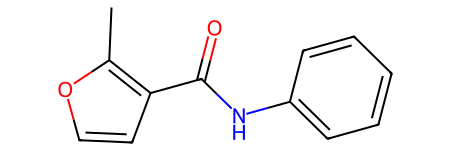

In [4]:
################################################
## Visualize a molecule using "smiles" string ##
################################################

# Get the smiles string of the 2nd molecule esol[1]
print(esol[1]['smiles']) # Cc1occc1C(=O)Nc2ccccc2

# Visualize molecule using smiles string
molecule = rdkit.Chem.MolFromSmiles(esol[1]['smiles']) # Create a molecule object from smiles string
molecule # Call out the molecule object to visulize it in Jupyter Notebook

In [5]:
#################
## Build a GCN ##
#################

import torch
from torch.nn import Linear, Tanh
from torch_geometric.nn import GCNConv, global_mean_pool, global_max_pool, Sequential # Must use Sequential from torch_geometric

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

embedding_size = 64

class GCN(torch.nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        torch.manual_seed(42)
        
        # PyG Sequential handles the flow of x and edge_index
        self.gcn = Sequential('x, edge_index', [
            (GCNConv(in_features, embedding_size), 'x, edge_index -> x'), # Initial conv, upscale from 9 features to 64 features
            Tanh(),
            (GCNConv(embedding_size, embedding_size), 'x, edge_index -> x'), # Some more message passing steps
            Tanh(),
            (GCNConv(embedding_size, embedding_size), 'x, edge_index -> x'), # Some more message passing steps
            Tanh(),
            (GCNConv(embedding_size, embedding_size), 'x, edge_index -> x'), # Some more message passing steps
            Tanh(),
        ])
        '''
        Sequential('x, edge_index', [...])
        -> "When someone calls this sequential block, they are going to provide two pieces of data, and I will refer to them as x and edge_index internally."
        
        'x, edge_index -> x'
        -> The "x, edge_index" are the variables passed into the layer's forward function. For a GCNConv, it literally executes: layer.forward(x, edge_index)
        -> The "-> x" is the variable name assigned to the result of that layer. It updates the internal state of x for the next step in the sequence.
        '''
        
        self.fc = Linear(embedding_size*2, out_features)

    def forward(self, x, edge_index, batch_index):
        hidden = self.gcn(x, edge_index)
        
        # Global pooling
        pooled = torch.cat([global_max_pool(hidden, batch_index),
                            global_mean_pool(hidden, batch_index)], dim=1)
        
        out = self.fc(pooled)
        return out, hidden
'''
What is batch_index?

When you train a standard neural network (like for images), you pass a 4D tensor of shape (Batch_Size, Channels, Height, Width). 
However, graphs have different numbers of nodes and edges, so you can't just stack them into a single uniform tensor.

Instead, PyG combines all graphs in a mini-batch into one giant, disjoint graph.

Imagine you have a batch of 3 molecules (graphs):
# Graph 0: 3 nodes
# Graph 1: 2 nodes
# Graph 2: 4 nodes

The batch_index vector would look like this: [0, 0, 0, 1, 1, 2, 2, 2, 2]
# The first 3 elements are 0, meaning nodes 0, 1, and 2 belong to the first molecule.
# The next 2 elements are 1, meaning nodes 3 and 4 belong to the second molecule.
# And so on. Its shape is always [total_number_of_nodes_in_batch].
'''

#-----
## Initialize model
#-----

model = GCN(in_features=esol.num_features, out_features=1) # out_features=1 since this is a regression task
model = model.to(device)

print(model)
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")

GCN(
  (gcn): Sequential(
    (0) - GCNConv(9, 64): x, edge_index -> x
    (1) - Tanh(): x -> x
    (2) - GCNConv(64, 64): x, edge_index -> x
    (3) - Tanh(): x -> x
    (4) - GCNConv(64, 64): x, edge_index -> x
    (5) - Tanh(): x -> x
    (6) - GCNConv(64, 64): x, edge_index -> x
    (7) - Tanh(): x -> x
  )
  (fc): Linear(in_features=128, out_features=1, bias=True)
)
Number of parameters: 13249


In [6]:
################################
## Optimizer, Loss, Scheduler ##
################################

loss_fn = torch.nn.MSELoss()

optimizer = torch.optim.Adam(
    params=model.parameters(), 
    lr=0.0007
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=50)

In [7]:
################################
## Training - Validating loop ##
################################

from tqdm.auto import tqdm

epochs = 1500

train_loss_list, val_loss_list = [], []

for epoch in tqdm(range(1, epochs+1, 1), desc="Training"):
    # --- TRAINING ---
    _ = model.train()
    train_loss = 0
    for batch in train_set:
        batch.to(device)
        X_batch = batch.x.float()
        y_batch = batch.y.float()
        
        y_preds, embedding = model(X_batch, batch.edge_index, batch.batch) # batch.batch to get the batch index
        
        loss = torch.sqrt(loss_fn(y_preds, y_batch))  # Remove .item() here
        train_loss += loss.item()  # Convert to float when accumulating
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # --- VALIDATION (Every epoch) ---
    _ = model.eval() 
    val_loss = 0
    with torch.inference_mode(): 
        for batch in val_set:
            batch.to(device)
            X_batch = batch.x.float()
            y_batch = batch.y.float()
            
            y_preds, embedding = model(X_batch, batch.edge_index, batch.batch) # batch.batch to get the batch index
            val_loss += torch.sqrt(loss_fn(y_preds, y_batch)).item()  # Move .item() after sqrt
    
    avg_val_loss = val_loss / len(val_set)
    avg_train_loss = train_loss / len(train_set)
    
    train_loss_list.append(avg_train_loss)  # Remove .item() since it's already a float
    val_loss_list.append(avg_val_loss)
    
    current_lr = optimizer.param_groups[0]['lr']
    
    scheduler.step(avg_val_loss)
    
    if (epoch % 150 == 0) or (epoch == 1):
        print("+"*50)
        print(f"Epoch: {epoch}")
        print(f"Train loss: {avg_train_loss:.3e}")
        print(f"Validation loss: {avg_val_loss:.3e}")
        print(f"Current lr: {current_lr}")


Training:   0%|          | 0/1500 [00:00<?, ?it/s]

++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch: 1
Train loss: 3.098e+00
Validation loss: 2.357e+00
Current lr: 0.0007
++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch: 150
Train loss: 9.883e-01
Validation loss: 1.084e+00
Current lr: 0.0007
++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch: 300
Train loss: 7.758e-01
Validation loss: 9.525e-01
Current lr: 0.0007
++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch: 450
Train loss: 6.907e-01
Validation loss: 8.786e-01
Current lr: 0.0007
++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch: 600
Train loss: 5.682e-01
Validation loss: 8.593e-01
Current lr: 0.0007
++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch: 750
Train loss: 4.823e-01
Validation loss: 7.593e-01
Current lr: 0.00035
++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch: 900
Train loss: 4.337e-01
Validation loss: 7.622e-01
Current lr: 4.375e-05
++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch: 1050
Train loss: 4.310e-01
Val

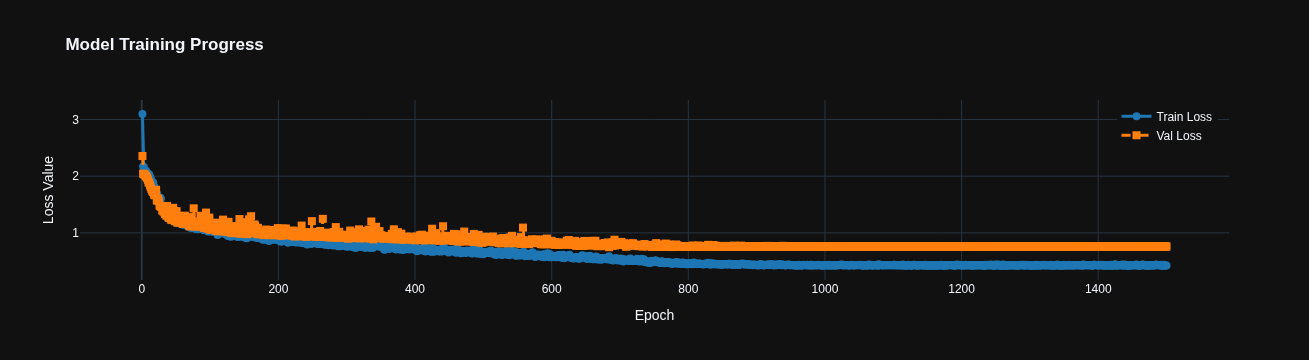

In [8]:
#######################################
## Drawing Train and Val loss curves ##
#######################################

def plot_train_val_loss_curves(epochs, train_loss_list, val_loss_list):
    import plotly.graph_objects as pgo
    import numpy as np
    
    # 1. Define the X-axis (epochs)
    epoch_axis = np.arange(1, epochs + 1, 1)

    fig = pgo.Figure()

    # 2. Add Training Loss
    fig.add_trace(pgo.Scatter(
        x=epoch_axis,
        y=train_loss_list,
        mode='lines+markers',
        name='Train Loss',
        line=dict(color='#1f77b4', width=3),
        marker=dict(size=8)
    ))

    # 3. Add Validation Loss
    fig.add_trace(pgo.Scatter(
        x=epoch_axis,
        y=val_loss_list,
        mode='lines+markers',
        name='Val Loss',
        line=dict(color='#ff7f0e', width=3, dash='dash'),
        marker=dict(size=8, symbol='square')
    ))

    # 4. Layout & Styling
    fig.update_layout(
        title='<b>Model Training Progress</b>',
        xaxis_title='Epoch',
        yaxis_title='Loss Value',
        template='plotly_dark', # Clean dark background
        hovermode='x unified',   # Shows both values on hover
        legend=dict(yanchor="top", y=0.99, xanchor="right", x=0.99)
    )

    fig.show()
    
plot_train_val_loss_curves(epochs, train_loss_list, val_loss_list)

Avg test loss: 0.7748126983642578


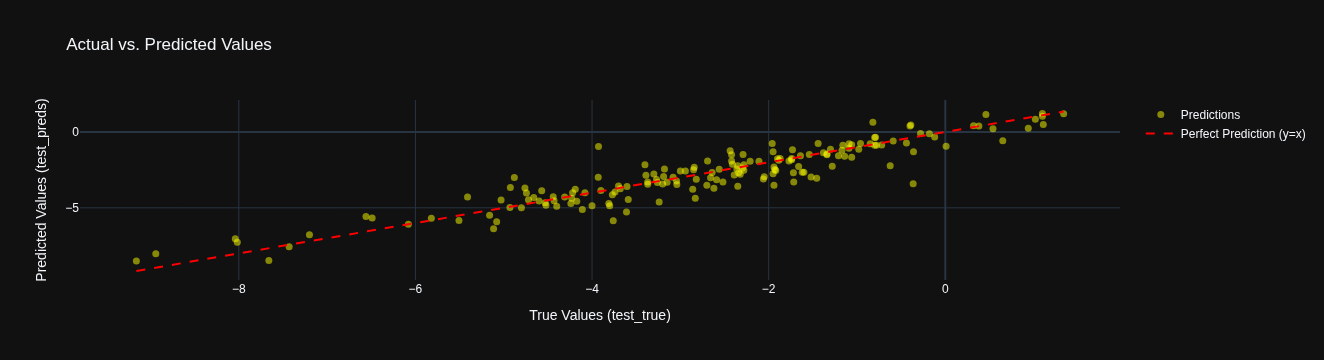

In [20]:
#############
## Testing ##
#############

_ = model.eval() 
test_loss = 0
test_preds, test_true = [], []
with torch.inference_mode(): 
    for batch in test_set:
        batch.to(device)
        X_batch = batch.x.float()
        y_batch = batch.y.float()
        
        y_preds, embedding = model(X_batch, batch.edge_index, batch.batch) # batch.batch to get the batch index
        test_loss += torch.sqrt(loss_fn(y_preds, y_batch)).item()  # Move .item() after sqrt
        
        test_true.append(y_batch.cpu().numpy())
        test_preds.append(y_preds.cpu().numpy())
        
avg_test_loss = test_loss / len(test_set)
print(f"Avg test loss: {avg_test_loss}")

#-----------
## Visualize y_preds, y_true
#-----------

import numpy as np

# Stack values from different batches into one array only, and then .squeeze() into 1D vectors
test_true = np.vstack(test_true).squeeze() 
test_preds = np.vstack(test_preds).squeeze()

import plotly.graph_objects as go

# Determine the bounds for the y=x reference line
min_val = min(test_true.min(), test_preds.min())
max_val = max(test_true.max(), test_preds.max())

fig = go.Figure()

# Add the scatter points
fig.add_trace(go.Scatter(
    x=test_true, 
    y=test_preds,
    mode='markers',
    name='Predictions',
    marker=dict(color='yellow', opacity=0.5, size=7)
))

# Add the y=x reference line
fig.add_trace(go.Scatter(
    x=[min_val, max_val], 
    y=[min_val, max_val],
    mode='lines',
    name='Perfect Prediction (y=x)',
    line=dict(color='red', dash='dash', width=2)
))

# Update appearance
fig.update_layout(
    title='Actual vs. Predicted Values',
    xaxis_title='True Values (test_true)',
    yaxis_title='Predicted Values (test_preds)',
    template='plotly_dark',
    showlegend=True
)

fig.show()